# Bayesian Accelerated Randomized Benchmarking

## Interleaved RB on Simulator

This is a bayesian pyMC3 implementation on top of frequentist interleaved RB from qiskit experiments

Based on the tutorial "randomized_benchmarking" of qiskit experiments version 0.2.0

The Bayesian sequential Monte Carlo (SMC) algorithms are based on equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.
The SMC model is based on equations 3,4 and 5 in [this paper](https://arxiv.org/abs/1404.5275) by Granade and al.

This demo shows that accelerated SMC delivers on simulator precise estimations of the error per Clifford, with narrow error bounds.

In [56]:
import numpy as np
import time
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# for retrieving gate  Reference
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import qiskit_bayesian_fitter as bf

In [58]:
# for WIP
import importlib
importlib.reload(bf)

<module 'qiskit_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\qiskit_bayesian_fitter.py'>

In [2]:
simulation = True # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_bogota') # type here hardware backend  

## one or two-qubit interleaved RB

In [47]:
# describe RB experiment (accept 1-qubit or 2-qubit interleaved gate)
interleaved_gate = "cx"
interleaved_circuit = circuits.CXGate()
qubits = [1,4]
lengths = np.arange(1, 200, 15)
num_samples = 10
seed = 1010

In [54]:
# get the backend's referencevalue
t = None # enter t in datetime format if necessary
# use properties(datetime=t) if t is defined
e_list = dv.gate_error_values(backend.properties()) 
epc_calib = np.nan
for tuple_e in e_list:
    if tuple_e[0] == interleaved_gate and tuple_e[1] == qubits:
        epc_calib = tuple_e[2]
print('EPC reference:    {0:1.4e}'.format(epc_calib)) 

EPC calibration: 1.2439e-02


### Prepare and run circuits using Qiskit experiments

In [5]:
#prepare circuits
int_exp = InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)
#run
print("start experiments",time.strftime('%d/%m/%Y %H:%M:%S'))
int_expdata = int_exp.run(backend).block_for_results()
print("  end experiments",time.strftime('%d/%m/%Y %H:%M:%S'))

start experiments 18/08/2021 23:21:14
  end experiments 18/08/2021 23:24:09


### Least-squares fit using qiskit experiments

In [6]:
#analyse
print("   start analysis",time.strftime('%d/%m/%Y %H:%M:%S'))
int_results = int_expdata.analysis_results()
print("     end analysis",time.strftime('%d/%m/%Y %H:%M:%S'))

   start analysis 18/08/2021 23:24:09
     end analysis 18/08/2021 23:24:09


   ### prepare for SMC

In [9]:
experiment_type = int_expdata._data[0]['metadata']['experiment_type']
physical_qubits = int_expdata._data[0]['metadata']['physical_qubits']
shots = int_expdata._data[0]['shots']
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)
# to compare ultimately: EPC and sigma(EPC) by LSF
epc_est_fm = int_expdata.analysis_results()[3].value.value
epc_est_fm_err = int_expdata.analysis_results()[3].value.stderr

In [64]:
# get count data and other values from int_expdata
Y = bf.get_GSP_counts(int_expdata._data, 2*m_len,
                    range(num_samples))

In [65]:
# get RvsI_h and IvsR_h
RvsI_h = np.ones(2*m_len) 
for i_data in range(2*m_len):
    if int_expdata._data[i_data]['metadata']['interleaved']:
            RvsI_h[i_data] = 0.  
IvsR_h = (RvsI_h + 1.) %2

In [12]:
X0 = np.tile(lengths,2)
X = np.vstack((X0,RvsI_h,IvsR_h))
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

###  Serial Monte Carlo, hierarchical model

Model based on: equations 3, 4 and 5 in [this paper](https://arxiv.org/abs/1404.5275) by Granade et al. and equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.

A good introduction to model creation and inference using PyMC3 can be found here: [General API quickstart — PyMC3 3.11.2 documentation](https://docs.pymc.io/pymc-examples/examples/pymc3_howto/api_quickstart.html).

In [13]:
model = "hierarchical_model"

In [14]:
# priors for unknown model parameters
T_priors = int_expdata.analysis_results()[0].value.value
print(T_priors)

[0.70304386 0.97169074 0.98366865 0.26212273]


In [15]:
# building the model
h_model = pm.Model()
with h_model:
    
    # Tying parameters
    BoundedUniform = pm.Bound(pm.Uniform,
                               lower=np.fmax(T_priors-0.1, np.full(T_priors.shape,1.e-9)),
                               upper=np.fmin(T_priors+0.1, np.full(T_priors.shape,1.-1e-9)))
    pi = BoundedUniform("Tying_Parameters",testval = T_priors, shape = T_priors.shape)
    EPC = pm.Deterministic('EPC', scale*(1-pi[2])) 
    
    # sigma of Beta functions
    sigma_t = pm.Uniform("σ_Beta",  testval = 0.005,
                            upper = 0.05, lower = 0.0005)    
    
    # Tying function
    GSP = pi[0] * ( X[1]*pi[1]**X[0] +\
                    X[2]*(pi[1]*pi[2])**X[0] ) +  pi[3]
                 
    theta = pm.Beta('θ', mu=GSP, sigma = sigma_t,
                     shape = ((2*len(lengths, ))) )                                 

    # Likelihood (sampling distribution) of observations    
    p = pm.Binomial("Counts", p = theta, observed = Y, n = shots) 

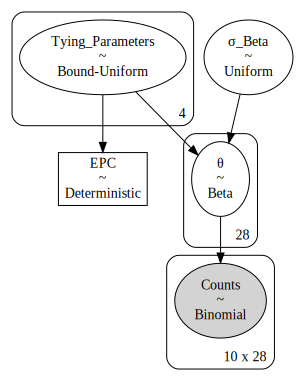

In [16]:
# model graph                                
pm.model_to_graphviz(h_model)

In [17]:
# sample
with h_model:
    trace_h = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 322 seconds.
The number of effective samples is smaller than 10% for some parameters.


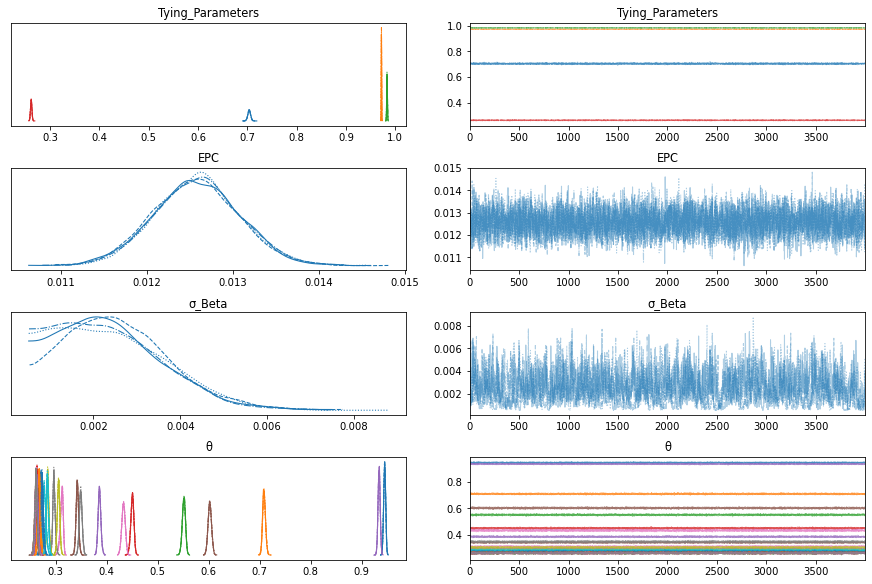

In [18]:
with h_model:
        az.plot_trace(trace_h);

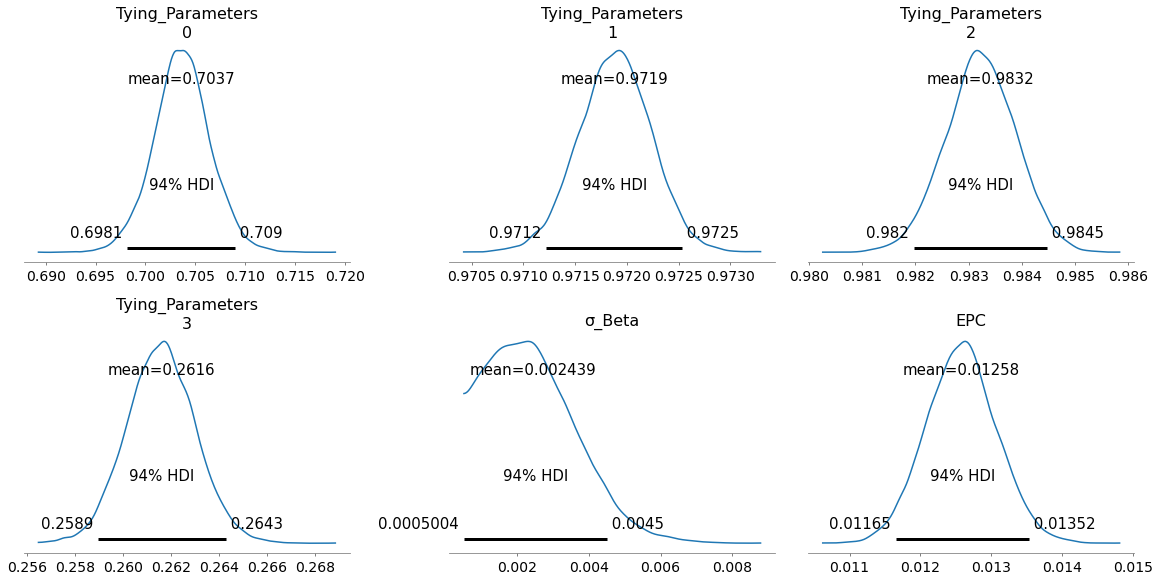

In [19]:
with h_model:
    az.plot_posterior(trace_h, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [20]:
# look at the posterior values of the hyperparameters:
with h_model:
    #  (hdi_prob=.94 is default)
    azt_summary = az.summary(trace_h, round_to=12,
                            var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                            kind="stats") 
azt_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.703664,0.002867,0.698144,0.709032
Tying_Parameters[1],0.971883,0.000352,0.971223,0.972535
Tying_Parameters[2],0.983231,0.000666,0.981968,0.984466
Tying_Parameters[3],0.261583,0.001436,0.258932,0.264304
σ_Beta,0.002439,0.001226,0.000500,0.004500
EPC,0.012577,0.000499,0.011650,0.013524


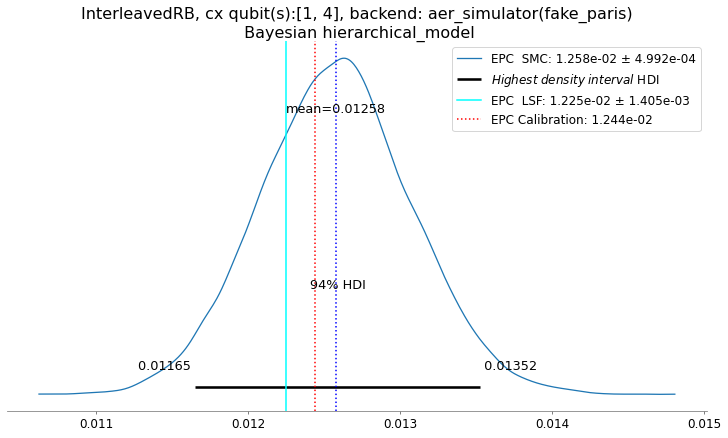

In [50]:
# mean and sigma of EPC
epc_est_a = azt_summary['mean']['EPC']
epc_est_a_err = azt_summary['sd']['EPC']

# plot 
import matplotlib.pyplot as plt # if not yet imported 

with h_model:
    az.plot_posterior(trace_h, var_names = ["EPC"],
                      round_to = 4, figsize = [10,6],
                      textsize = 12) 

Bayes_legend =  "EPC  SMC: {0:1.3e} ± {1:1.3e}"\
                    .format(epc_est_a, epc_est_a_err)
LSF_legend =    "EPC  LSF: {0:1.3e} ± {1:1.3e}".format(epc_est_fm, epc_est_fm_err)  
Cal_legend =    "EPC reference:    {0:1.3e}".format(epc_calib)
plt.axvline(x=epc_est_fm,color='cyan',ls="-")    
if epc_calib != np.nan:
    plt.axvline(x=epc_calib,color='r',ls=":")
plt.axvline(x=epc_est_a,color='blue',ls=":")
if epc_calib > 0.0:   
    plt.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                LSF_legend,
                Cal_legend), fontsize=12 )
else: 
    plt.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                LSF_legend))
plt.title(experiment_type +', ' + interleaved_gate  + " qubit(s):" + str(physical_qubits)\
                     +', backend: '+backend.name() + "\n Bayesian "+model,
                     fontsize=16);

In [22]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian         Reference")
print("__________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}         {2:1.3e}"
      .format(epc_est_fm,epc_est_a,epc_calib ))  
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))

Model:    Frequentist         Bayesian        Calibration
__________________________________________________________
EPC         1.225e-02        1.258e-02         1.244e-02
± sigma    ± 1.405e-03      ± 4.992e-04 


#### routine for computing  the optimized function based on this [document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html):

In [23]:
def calc_chisquare(ydata, sigma, ycalc): 
    r = ydata - ycalc
    chisq = np.sum((r / sigma) ** 2)
    return chisq

### GSP plot

In [24]:
# prepare box for GSP plot

# perform reduced χ² value calculation for Bayes hierarchical 
mean_h = trace_h.posterior.mean(dim=['chain', 'draw'])
theta_stacked = mean_h.θ.values
NDF_h = m_len*2 - 4 - 1 # (-1 is for σ_Beta)
chisq_h = calc_chisquare(y_mean, sigma_y, theta_stacked)/NDF_h

texto_0 = "  alpha = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['Tying_Parameters[1]'],
            azt_summary['sd']['Tying_Parameters[1]'])                                              

texto_1 =" alpha_c = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['Tying_Parameters[2]'],
            azt_summary['sd']['Tying_Parameters[2]'])                                              

texto_2 = "   EPC = {0:1.4e} ± {1:1.4e}"\
            .format(azt_summary['mean']['EPC'],
            azt_summary['sd']['EPC'])

texto_3 = "             Fit χ² = {0:7.4f} "\
            .format(chisq_h)

texto = texto_0 + "\n" + texto_1 + "\n" + texto_2 + "\n" + texto_3

In [86]:
# prepare data for GSP plot
# get the calculated GSP values
with h_model:
    hdi_prob = .94
    #  (hdi_prob=.94 is default, roughly corresponding to 2σ)
    theta_summary = az.summary(trace_h, round_to=12, hdi_prob = hdi_prob,
                            var_names = ["θ"], kind="stats")
y1 = theta_summary.values[:,0][0:m_len]
y2 = theta_summary.values[:,0][m_len:m_len*2]  

HDI = True # make your choice here
if HDI:
    # HDI values as bounds
    bounds_rmk = "(shown bounds are "+ str(int(100*hdi_prob)) + "% HDI)"
    y1_min = theta_summary.values[:,2][0:m_len]
    y2_min = theta_summary.values[:,2][m_len:m_len*2]
    y1_max = theta_summary.values[:,3][0:m_len]
    y2_max = theta_summary.values[:,3][m_len:m_len*2]
else:    
    # two sigma bounds for plot
    bounds_rmk = "(shown bounds are ± two σ)"
    sy = theta_summary.values[:,1]
    y1_min = y1 - sy[0:m_len]*2
    y1_max = y1 + sy[0:m_len]*2
    y2_min = y2 - sy[m_len:m_len*2]*2
    y2_max = y2 + sy[m_len:m_len*2]*2    

# get the individual counts for the two curves standard and interleave
Y1_mask = np.tile(np.array(IvsR_h,dtype=bool), num_samples)
Y2_mask = np.tile(np.array(RvsI_h,dtype=bool), num_samples)
Y1 = np.reshape(np.delete(Y,Y1_mask),((num_samples,m_len)))
Y2 = np.reshape(np.delete(Y,Y2_mask),((num_samples,m_len)))

In [81]:
# for WIP
import importlib
importlib.reload(bf)

<module 'qiskit_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\qiskit_bayesian_fitter.py'>

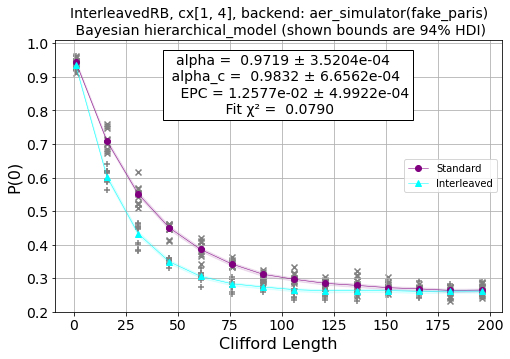

In [85]:
title = experiment_type +', ' + interleaved_gate\
          + str(physical_qubits)\
          +', backend: '+backend.name()+\
          "\n Bayesian "+model+" "+ bounds_rmk
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2, y2_min, y2_max, Y1, Y2,
         first_curve = "Standard", second_curve = "Interleaved")

#### compare with frequentist model results

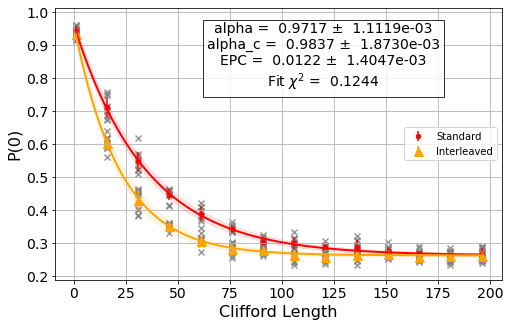

In [28]:
# View result data for frequentist model
display(int_expdata.figure(0))